In [1]:
from IPython.display import YouTubeVideo

# 1. Intro

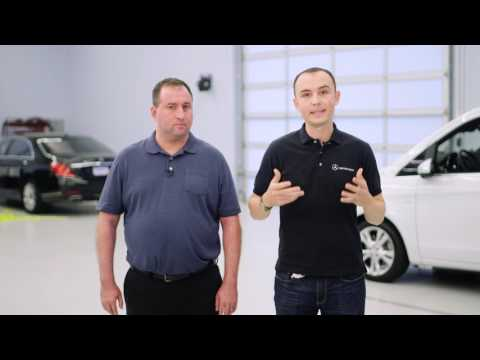

In [2]:
YouTubeVideo('G57ZvTBAUL8', width=960, height=540)

# 2. Lesson Map and Fusion Flow

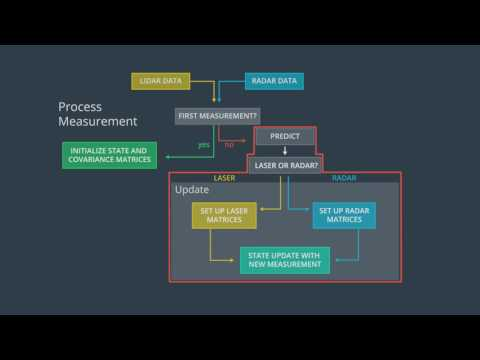

In [3]:
YouTubeVideo('_u8Vk58VqxY', width=960, height=540)

## Overview of the Kalman Filter Algorithm Map

![title](img/fusion-map.png)
<center>For your reference: a map of the Kalman Filter algorithm! Keep an eye out, because we'll add a little bit more detail to this later.</center>

Imagine you are in a car equipped with sensors on the outside. The car sensors can detect objects moving around: for example, the sensors might detect a bicycle.

The Kalman Filter algorithm will go through the following steps:

* **first measurement** - the filter will receive initial measurements of the bicycle's position relative to the car. These measurements will come from a radar or lidar sensor.
* **initialize state and covariance matrices** - the filter will initialize the bicycle's position based on the first measurement.
* then the car will receive another sensor measurement after a time period Δt.
* **predict** - the algorithm will predict where the bicycle will be after time Δt. One basic way to predict the bicycle location after Δt is to assume the bicycle's velocity is constant; thus the bicycle will have moved velocity * Δt. In the extended Kalman filter lesson, we will assume the velocity is constant; in the unscented Kalman filter lesson, we will introduce a more complex motion model.
* **update** - the filter compares the "predicted" location with what the sensor measurement says. The predicted location and the measured location are combined to give an updated location. The Kalman filter will put more weight on either the predicted location or the measured location depending on the uncertainty of each value.
* then the car will receive another sensor measurement after a time period Δt. The algorithm then does another **predict** and **update** step.

# 3. Lesson Variables and Equations

## There are so many equations!
In order to help you following along with the derivations of the Kalman Filter equations in this lesson, we're providing a handy dandy cheat sheet (actually "sheets", because there are a few pages). I want to call your attention to the resources panel on the left (see the screenshot below) where you can find a PDF copy of this cheat sheet entitled "Sensor Fusion EKF Reference.pdf."

Download it and keep going with the lesson!

[sensor-fusion-ekf-reference.pdf](sensor-fusion-ekf-reference.pdf)


# 4. Estimation Problem Refresh

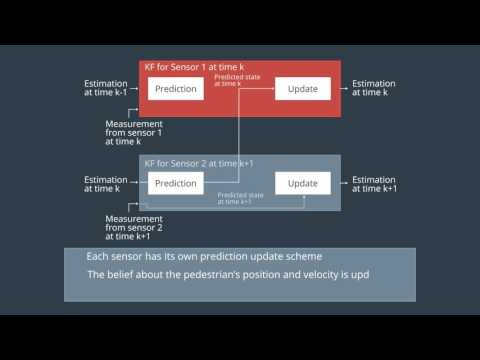

In [4]:
YouTubeVideo('Uwq7_6slV_M', width=960, height=540)

## Definition of Variables

- $x$ is the mean state vector. For an extended Kalman filter, the mean state vector contains information about the object's position and velocity that you are tracking. It is called the "mean" state vector because position and velocity are represented by a gaussian distribution with mean $x$.
- $P$ is the state covariance matrix, which contains information about the uncertainty of the object's position and velocity. You can think of it as containing standard deviations.
- k represents time steps. So $x_{k}$ refers to the object's position and velocity vector at time k.
- The notation $k+1∣k$ refers to the prediction step. At time $k+1$, you receive a sensor measurement. Before taking into account the sensor measurement to update your belief about the object's position and velocity, you predict where you think the object will be at time $k+1$. You can predict the position of the object at $k+1$ based on its position and velocity at time $k$. Hence $x_{k+1∣k}$ means that you have predicted where the object will be at $k+1$ but have not yet taken the sensor measurement into account.
- $x_{k+1}$ means that you have now predicted where the object will be at time $k+1$ and then used the sensor measurement to update the object's position and velocity.

<img src="img/screen-shot-2017-02-27-at-17.52.45.png">

## QUIZ QUESTION

What should a Kalman Filter do if both the radar and laser measurements arrive at the same time, k+3? Hint: The Kalman filter algorithm predicts -> updates -> predicts -> updates, etc. If two sensor measurements come in simultaneously, the time step between the first measurement and the second measurement would be zero.

- (A) Predict the state to k+3, and then update the state with only one of those measurements, either laser or radar.
- (B) Predict the state to k+3, and then only update with the laser measurement because it is more accurate.
- (C) Predict the state to k+3 then use either one of the sensors to update. Then predict the state to k+3 again and update with the other sensor measurement.
- (D) Skip the prediction step because we have two measurements. Just update the prior probability distribution twice.

Answer: C. As you saw, the Kalman filter is a two-step process: predict, and then update. If you receive two measurements simultaneously, you can use this process with either measurement and then repeat the process with the other measurement. The order does not matter!

# 5. Kalman Filter Intuition

## Additional Info about the Last Quiz

<img src="img/measureupdatequizpost.png">

Because we have already run a prediction-update iteration with the first sensor at time k+3, the output of the second prediction at time k+3 will actually be identical to the output from the update step with the first sensor. So, in theory, you could skip the second prediction step and just run a prediction, update, update iteration.

But you'll learn more about that later. First, a bit of math.

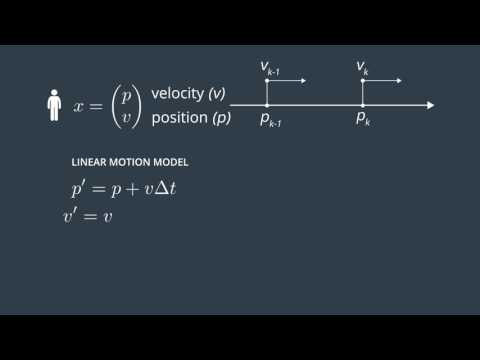

In [5]:
YouTubeVideo('ZG8Ya-mCGhI', width=960, height=540)

## Kalman Filter Intuition
The Kalman equation contains many variables, so here is a high level overview to get some intuition about what the Kalman filter is doing.

### Prediction
Let's say we know an object's current position and velocity , which we keep in the x variable. Now one second has passed. We can predict where the object will be one second later because we knew the object position and velocity one second ago; we'll just assume the object kept going at the same velocity.

The $x′= Fx+ν$ equation does these prediction calculations for us.

But maybe the object didn't maintain the exact same velocity. Maybe the object changed direction, accelerated or decelerated. So when we predict the position one second later, our uncertainty increases. $P′= FPF^T + Q$ represents this increase in uncertainty.

Process noise refers to the uncertainty in the prediction step. We assume the object travels at a constant velocity, but in reality, the object might accelerate or decelerate. The notation $ν \sim N(0,Q)$ defines the process noise as a gaussian distribution with mean zero and covariance Q.

### Update
Now we get some sensor information that tells where the object is relative to the car. First we compare where we think we are with what the sensor data tells us $y = z − Hx′$.

The $K$ matrix, often called the Kalman filter gain, combines the uncertainty of where we think we are $P′$ with the uncertainty of our sensor measurement $R$. If our sensor measurements are very uncertain ($R$ is high relative to $P'$), then the Kalman filter will give more weight to where we think we are: $x′$. If where we think we are is uncertain ($P'$ is high relative to $R$), the Kalman filter will put more weight on the sensor measurement: $z$.

Measurement noise refers to uncertainty in sensor measurements. The notation $ω \sim N(0,R)$ defines the measurement noise as a gaussian distribution with mean zero and covariance $R$. Measurement noise comes from uncertainty in sensor measurements.

## A Note About the State Transition Function: Bu
If you go back to the video, you'll notice that the state transition function was first given as $x′ = Fx + Bu + ν$.

But then $Bu$ was crossed out leaving $x′ = Fx + ν$.

$B$ is a matrix called the control input matrix and $u$ is the control vector.

As an example, let's say we were tracking a car and we knew for certain how much the car's motor was going to accelerate or decelerate over time; in other words, we had an equation to model the exact amount of acceleration at any given moment. $Bu$ would represent the updated position of the car due to the internal force of the motor. We would use $ν$ to represent any random noise that we could not precisely predict like if the car slipped on the road or a strong wind moved the car.

For the Kalman filter lessons, we will assume that there is no way to measure or know the exact acceleration of a tracked object. For example, if we were in an autonomous vehicle tracking a bicycle, pedestrian or another car, we would not be able to model the internal forces of the other object; hence, we do not know for certain what the other object's acceleration is. Instead, we will set Bu=0 and represent acceleration as a random noise with mean $ν$.

# 6. Kalman Filter Equations in C++ Part 1

## Kalman Filter Equations in C++
Now, let's do a quick refresher of the Kalman Filter for a simple 1D motion case. Let's say that your goal is to track a pedestrian with state x that is described by a position and velocity.

$x = \begin{pmatrix}p \\v \end{pmatrix} $


### Prediction Step
When designing the Kalman filter, we have to define the two linear functions: the state transition function and the measurement function. The state transition function is

$x′ = F∗x + noise$,

where,

$F= \begin{pmatrix}1 & Δt \\ 0 & 1 \end{pmatrix} $

and $x′$ is where we predict the object to be after time $Δt$.

$F$ is a matrix that, when multiplied with $x$, predicts where the object will be after time $Δt$.

By using the linear motion model with a constant velocity, the new location, $p′$ is calculated as

$p′ = p + v∗Δt$,

where $p$ is the old location and $v$, the velocity, will be the same as the new velocity ($v′= v$) because the velocity is constant.

We can express this in a matrix form as follows:

$ \begin{pmatrix}p' \\ v' \end{pmatrix} = \begin{pmatrix}1 & Δt \\ 0 & 1 \end{pmatrix} \begin{pmatrix}p \\ v \end{pmatrix} $

Remember we are representing the object location and velocity as gaussian distributions with mean $x$. When working with the equation $x′ = Fx + noise$, we are calculating the mean value of the state vector. The noise is also represented by a gaussian distribution but with mean zero; hence, $noise = 0$ is saying that the mean noise is zero. The update equation then becomes $x′ = F∗x$

But the noise does have uncertainty. The uncertainty shows up in the $Q$ matrix as acceleration noise.

### Update Step
For the update step, we use the measurement function to map the state vector into the measurement space of the sensor. To give a concrete example, lidar only measures an object's position. But the extended Kalman filter models an object's position and velocity. So multiplying by the measurement function H matrix will drop the velocity information from the state vector $x$. Then the lidar measurement position and our belief about the object's position can be compared.

$z = H∗x + w$

where $w$ represents sensor measurement noise.

So for lidar, the measurement function looks like this:

$z = p′$.

It also can be represented in a matrix form:

$z = \begin{pmatrix}1 & 0\end{pmatrix}\begin{pmatrix}p' \\ v'\end{pmatrix}$.

As we already know, the general algorithm is composed of a prediction step where I predict the new state and covariance, $P$.

And we also have a measurement update (or also called many times a correction step) where we use the latest measurements to update our estimate and our uncertainty.

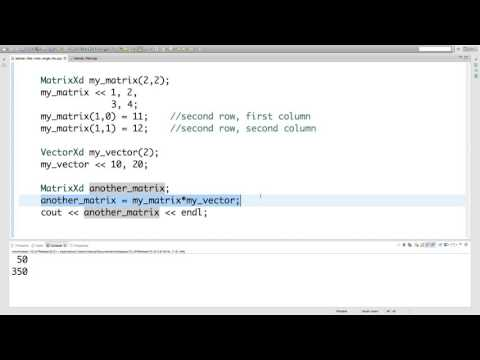

In [6]:
YouTubeVideo('KV4ZdUnOz9I', width=960, height=540)

Here is a download link to the [Eigen Library](https://d17h27t6h515a5.cloudfront.net/topher/2017/March/58b7604e_eigen/eigen.zip) that is being used throughout the programming assignments. Further details regarding this library can be found [here](http://eigen.tuxfamily.org/).

Note: In the classroom editor we are calling just Dense instead of Eigen/Dense as seen in videos. This is because the Eigen library had to have its folder structure reformatted to work with the programming quiz editor. If you run the code on your own computer you would still use Eigen/Dense.

```c++
// Write a function 'filter()' that implements a multi-
// dimensional Kalman Filter for the example given
//============================================================================
#include <iostream>
#include "Dense"
#include <vector>

using namespace std;
using namespace Eigen;

//Kalman Filter variables
VectorXd x;	// object state
MatrixXd P;	// object covariance matrix
VectorXd u;	// external motion
MatrixXd F; // state transition matrix
MatrixXd H;	// measurement matrix
MatrixXd R;	// measurement covariance matrix
MatrixXd I; // Identity matrix
MatrixXd Q;	// process covariance matrix

vector<VectorXd> measurements;
void filter(VectorXd &x, MatrixXd &P);


int main() {
	/**
	 * Code used as example to work with Eigen matrices
	 */
//	//you can create a  vertical vector of two elements with a command like this
//	VectorXd my_vector(2);
//	//you can use the so called comma initializer to set all the coefficients to some values
//	my_vector << 10, 20;
//
//
//	//and you can use the cout command to print out the vector
//	cout << my_vector << endl;
//
//
//	//the matrices can be created in the same way.
//	//For example, This is an initialization of a 2 by 2 matrix
//	//with the values 1, 2, 3, and 4
//	MatrixXd my_matrix(2,2);
//	my_matrix << 1, 2,
//			3, 4;
//	cout << my_matrix << endl;
//
//
//	//you can use the same comma initializer or you can set each matrix value explicitly
//	// For example that's how we can change the matrix elements in the second row
//	my_matrix(1,0) = 11;    //second row, first column
//	my_matrix(1,1) = 12;    //second row, second column
//	cout << my_matrix << endl;
//
//
//	//Also, you can compute the transpose of a matrix with the following command
//	MatrixXd my_matrix_t = my_matrix.transpose();
//	cout << my_matrix_t << endl;
//
//
//	//And here is how you can get the matrix inverse
//	MatrixXd my_matrix_i = my_matrix.inverse();
//	cout << my_matrix_i << endl;
//
//
//	//For multiplying the matrix m with the vector b you can write this in one line as let’s say matrix c equals m times v.
//	//
//	MatrixXd another_matrix;
//	another_matrix = my_matrix*my_vector;
//	cout << another_matrix << endl;


	//design the KF with 1D motion
	x = VectorXd(2);
	x << 0, 0;

	P = MatrixXd(2, 2);
	P << 1000, 0, 0, 1000;

	u = VectorXd(2);
	u << 0, 0;

	F = MatrixXd(2, 2);
	F << 1, 1, 0, 1;

	H = MatrixXd(1, 2);
	H << 1, 0;

	R = MatrixXd(1, 1);
	R << 1;

	I = MatrixXd::Identity(2, 2);

	Q = MatrixXd(2, 2);
	Q << 0, 0, 0, 0;

	//create a list of measurements
	VectorXd single_meas(1);
	single_meas << 1;
	measurements.push_back(single_meas);
	single_meas << 2;
	measurements.push_back(single_meas);
	single_meas << 3;
	measurements.push_back(single_meas);

	//call Kalman filter algorithm
	filter(x, P);

	return 0;

}


void filter(VectorXd &x, MatrixXd &P) {

	for (unsigned int n = 0; n < measurements.size(); ++n) {

		VectorXd z = measurements[n];
		//YOUR CODE HERE
		
		// KF Measurement update step
		 
		// new state
		
		// KF Prediction step
		
		std::cout << "x=" << std::endl <<  x << std::endl;
		std::cout << "P=" << std::endl <<  P << std::endl;


	}
}
```

# 7. Kalman Filter Equations in C++ Part 2

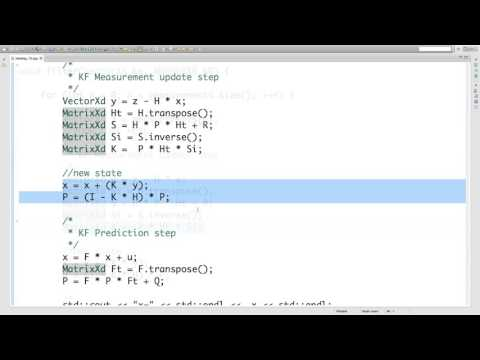

In [7]:
YouTubeVideo('smRjTGQG2SY', width=960, height=540)

```c++
void filter(VectorXd &x, MatrixXd &P) {

	for (unsigned int n = 0; n < measurements.size(); ++n) {

		VectorXd z = measurements[n];
		//YOUR CODE HERE
		/*
		 * KF Measurement update step
		 */
		VectorXd y = z - H * x;
		MatrixXd Ht = H.transpose();
		MatrixXd S = H * P * Ht + R;
		MatrixXd Si = S.inverse();
		MatrixXd K =  P * Ht * Si;

		//new state
		x = x + (K * y);
		P = (I - K * H) * P;

		/*
		 * KF Prediction step
		 */
		x = F * x + u;
		MatrixXd Ft = F.transpose();
		P = F * P * Ft + Q;

		std::cout << "x=" << std::endl <<  x << std::endl;
		std::cout << "P=" << std::endl <<  P << std::endl;


	}
}
```

## QUESTION 2 OF 2

Why do we not use the process noise in the state prediction function, even though the state transition equation has one? In other words, why does the code set u << 0, 0 for the equation x = F * x + u?

- (A) Because the process noise is just an approximation and we do not include the noise
- (B) The noise mean is zero
- (C) We should! There's a bug in the function.
- (D) The noise mean is too large.

Answer: (B). Looking closely at the process noise, we know from the Kalman Filter algorithm that its mean is zero and its covariance matrix is usually noted by $Q∗N(0,Q)$. The first equation only predicts the mean state. As the mean value of the noise is zero, it does not directly affect the predicted state. However, we can see that the noise covariance Q is added here to the state covariance prediction so that the state uncertainty always increases through the process noise.

# 8. State Prediction

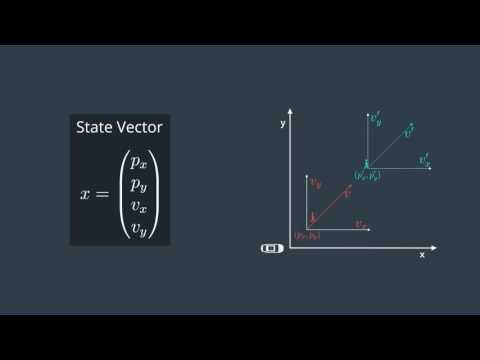

In [8]:
YouTubeVideo('_A0NRvmgo3w', width=960, height=540)

## The State Transition Matrix

$ \begin{pmatrix}p'_{x} \\ p'_{y} \\ v'_{x} \\ v'_{y}\end{pmatrix} = \begin{pmatrix}1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1\end{pmatrix} \begin{pmatrix} p_{x} \\ p_{y} \\ v_{x} \\ v_{y} \end{pmatrix} + \begin{pmatrix} v_{px} \\ v_{py} \\ v_{vx} \\ v_{vy} \end{pmatrix}$

As a reminder, the above equation is $x′ = Fx + noise$

Motion noise and process noise refer to the same case: uncertainty in the object's position when predicting location. The model assumes velocity is constant between time intervals, but in reality we know that an object's velocity can change due to acceleration. The model includes this uncertainty via the process noise.

Measurement noise refers to uncertainty in sensor measurements, which will be discussed in more detail later.


## QUESTION 1 OF 2

Suppose you have a pedestrian state X. I want you to compare two scenarios: in the first predict the state 0.1s into the future and in the second 5s into the future. Which of these two scenarios leads to a higher uncertainty? In answering this, consider whether or not random noise has an increasing effect with increasing gaps between prediction times.

- (A) A time difference of 0.1s leads to a higher uncertainty.
- (B) A time difference of 5s leads to a higher uncertainty.
- (C) Both time differences have the same uncertainty.

Answer: (B). Here's another way of thinking about it: if you split the 5s time difference into several intermediate predictions with a difference of 0.1s, then compared to the first case, you will predict the same state many more times without receiving any feedback about the object's new position. Thus, the uncertainty increases.

## QUESTION 2 OF 2

Let's say we use our linear motion model with fixed time increments, but the pedestrian is randomly changing her velocity (accelerating), sometimes speeding up, slowing down or changing direction. However, the overall mean change is zero. This introduces a noise in the tracking process - what kind of noise is it?

- (A) Measurement noise
- (B) Process noise
- (C) Neither!

Answer: B. The prediction equation treats the pedestrian's velocity as constant. As such, a randomly accelerating pedestrian creates a process noise.

<hr>

From the examples I’ve just showed you we can clearly see that the process noise depends on both: the elapsed time and the uncertainty of acceleration. So, how can we model the process noise by considering both of these factors? Keep going to find out :)

# 9. Process Covariance Matrix

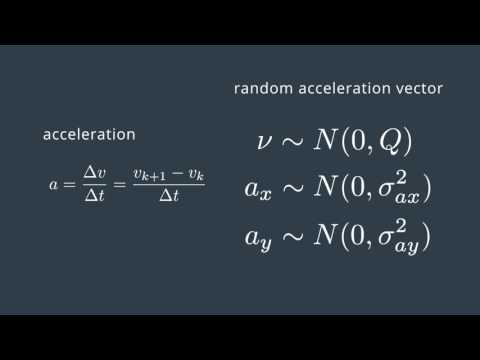

In [9]:
YouTubeVideo('iFcIiqRGaws', width=960, height=540)

## Calculating Acceleration Noise Parameters
Before we discuss the derivation of the process covariance matrix Q, you might be curious about how to choose values for $\sigma_{ax}^2$ and $\sigma_{ay}^2$.

For the extended Kalman filter project, you will be given values for both. The unscented Kalman filter lessons will describe how to choose values for the acceleration noise parameters.


## Process Covariance Matrix Q - Intuition
As a reminder, here are the state covariance matrix update equation and the equation for Q.

$P′=FPF^T+Q$

$Q=\begin{pmatrix} \frac{\Delta t^4}{4}\sigma^2_{ax} & 0 & \frac{\Delta t^3}{2}\sigma^2_{ax} & 0 \\ 0 & \frac{\Delta t^4}{4}\sigma^2_{ay} & 0 & \frac{\Delta t^3}{2}\sigma^2_{ay}  \\ \frac{\Delta t^3}{2}\sigma^2_{ax} & 0 & \Delta t^2\sigma^2_{ax} & 0 \\ 0 & \frac{\Delta t^3}{2}\sigma^2_{ay}  & 0 & \Delta t^2\sigma^2_{ay} \end{pmatrix} $

Because our state vector only tracks position and velocity, we are modeling acceleration as a random noise. The Q matrix includes time Δt to account for the fact that as more time passes, we become more uncertain about our position and velocity. So as Δt increases, we add more uncertainty to the state covariance matrix P.

Combining both 2D position and 2D velocity equations previously deducted formulas we have: $ \begin{cases} p'_{x} = p_{x} + v_{x}\Delta t + \frac{a_{x}\Delta t^2}{2} \\ p'_{y} = p_{y} + v_{y}\Delta t + \frac{a_{y}\Delta t^2}{2} \\ v'_{x} = v_{x} + a_{x}\Delta t \\ v'_{y} = v_{y} + a_{y}\Delta t \end{cases}$


Since the acceleration is unknown we can add it to the noise component, and this random noise would be expressed analytically as the last terms in the equation derived above. So, we have a random acceleration vector $\nu$ in this form:

$\nu=\begin{pmatrix} \nu_{px} \\ \nu_{py} \\ \nu_{vx} \\ \nu_{vy} \end{pmatrix} = \begin{pmatrix} \frac{a_{x}\Delta t^2}{2} \\ \frac{a_{y}\Delta t^2}{2} \\ a_{x}\Delta t \\ a_{y} \Delta t \end{pmatrix} $

which is described by a zero mean and a covariance matrix $Q$, so $ν∼N(0,Q)$.

The vector $ν$ can be decomposed into two components a 4 by 2 matrix $G$ which does not contain random variables and a 2 by 1 matrix a which contains the random acceleration components:

$\nu = \begin{pmatrix} \frac{a_{x}\Delta t^2}{2} \\ \frac{a_{y}\Delta t^2}{2} \\ a_{x}\Delta t \\ a_{y} \Delta t \end{pmatrix} = \begin{pmatrix} \frac{\Delta t^2}{2} & 0 \\ 0 & \frac{\Delta t^2}{2} \\ \Delta t & 0 \\ 0 & \Delta t \end{pmatrix}\begin{pmatrix} a_{x} \\ a_{y} \end{pmatrix} = G_{a}$ 


$\Delta t$ is computed at each Kalman Filter step and the acceleration is a random vector with zero mean and standard deviations $\sigma_{ax}$ and $\sigma_{ay}$.

Based on our noise vector we can define now the new covariance matrix $Q$.
The covariance matrix is defined as the expectation value of the noise vector $\nu$ times the noise vector $\nu^T$. So let’s write this down:

$Q = E[\nu \nu^T] = E[Gaa^TG^T]$

As $G$ does not contain random variables, we can put it outside the expectation calculation.

$Q = G E[aa^T] G^T = G \begin{pmatrix}
\sigma_{ax}^2 & \sigma_{axy} \\
\sigma_{axy} & \sigma_{ay}^2
\end{pmatrix}
G^T = G Q_{\nu} G^T$


This leaves us with three statistical moments:
- the expectation of ax times ax, which is the variance of ax: $\sigma^2_{ax}$ squared.
- the expectation of ay times ay, which is the variance of ay: $\sigma^2_{ay}$  squared.
- and the expectation of ax times ay, which is the covariance of $ax$ and $ay: \sigma_{axy}$.


$a_x$ and $a_y$ are assumed uncorrelated noise processes. This means that the covariance $\sigma_{axy}$ in $Q_{\nu}$ is zero:

$Q_{\nu} = \begin{pmatrix}
\sigma_{ax}^2 & \sigma_{axy} \\
\sigma_{axy} & \sigma_{ay}^2
\end{pmatrix}
\begin{pmatrix}
\sigma_{ax}^2 & 0 \\
0 & \sigma_{ay}^2
\end{pmatrix}$

So after combining everything in one matrix we obtain our 4 by 4 $Q$ matrix:

$Q = G Q_{\nu} G^T = 
\begin{pmatrix}
\frac{\Delta t^4}{{4}}\sigma_{ax}^2 & 0 & \frac{\Delta t^3}{{2}}\sigma_{ax}^2 & 0 \\
0 & \frac{\Delta t^4}{{4}}\sigma_{ay}^2 & 0 & \frac{\Delta t^3}{{2}}\sigma_{ay}^2 \\
\frac{\Delta t^3}{{2}}\sigma_{ax}^2 & 0 & \Delta t^2\sigma_{ax}^2 & 0 \\
0 & \frac{\Delta t^3}{{2}}\sigma_{ay}^2 & 0 & \Delta t^2\sigma_{ay}^2
\end{pmatrix}$

## Note on Notation
Some authors describe $Q$ as the complete process noise covariance matrix. And some authors describe $Q$ as the covariance matrix of the individual noise processes. In our case, the covariance matrix of the individual noise processes matrix is called $Q_\nu$, which is something to be aware of.

# 10. Laser Measurements Part 1

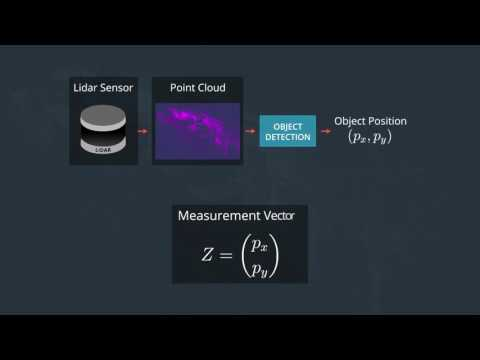

In [10]:
YouTubeVideo('drbV05qKV8w', width=960, height=540)

## Variable Definitions
To reinforce was what discussed in the video, here is an explanation of what each variable represents:

- *z* is the measurement vector. For a lidar sensor, the z vector contains the position−x and position−y measurements.
- *H* is the matrix that projects your belief about the object's current state into the measurement space of the sensor. For lidar, this is a fancy way of saying that we discard velocity information from the state variable since the lidar sensor only measures position: The state vector $x$ contains information about $[p_{x}, p_{y}, v_{x}, v_{y}]$  whereas the $z$ vector will only contain $[p_{x}, p_{y}]$. Multiplying Hx allows us to compare x, our belief, with z, the sensor measurement.
- What does the prime notation in the $x$ vector represent? The prime notation like $p'_{x}$ means you have already done the prediction step but have not done the measurement step yet. In other words, the object was at $p_{x}$. After time $Δt$, you calculate where you believe the object will be based on the motion model and get $p'_{x}$.


## H Matrix Quiz
Find the right H matrix to project from a 4D state to a 2D observation space, as follows:

$\begin{pmatrix}
p_x \\
p_y
\end{pmatrix} = H \begin{pmatrix}
p_x' \\
p_y' \\
v_x' \\
v_y'
\end{pmatrix}$

Here are your options:

A. $H = \begin{pmatrix}
1 & 0 \\
0 & 1
\end{pmatrix}$

B. $H = \begin{pmatrix}
1 & 0 \\
0 & 1 \\
0 & 0 \\
0 & 0
\end{pmatrix}$

C. $H = \begin{pmatrix}
1 & 1
\end{pmatrix}$

D. $H = \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{pmatrix}$

(Hint: first consider the matrix dimensions, then try to use a 0 or 1 to correctly project the components into the measurement space.)

## QUIZ QUESTION

Select the correct H matrix given the projection above.

Answer: D.

# 11. Laser Measurements Part 2

## H Matrix Quiz Explanation

$H=\begin{pmatrix}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \end{pmatrix} $


In order to obtain our measurement (x and y) we need to determine the H matrix. (x and y) is found by multiplying H with the state vector.

So let’s find out first what is the dimension of our H matrix. Here we have a 2 by 1 matrix, and that came from our m by n H matrix times the four row and one column matrix. Now, from the matrix multiplication we know that the number of columns of the first matrix should be equal with the number of rows of a second matrix, which is 4. And also the number of rows of the first matrix is the same with the number of rows of the result matrix, which is 2. So our H is a matrix of 2 rows and 4 columns. And finally we put ones and zeroes so that the px and py coordinates are propagated to the result Z.

## Measurement Noise Covariance Matrix R
Now, let's take a look at the covariance matrix, R, which represents the uncertainty in our sensor measurements. The dimensions of the R matrix is square and each side of its matrix is the same length as the number of measurements parameters. Before diving into the details, let's have a quick quiz to test your intuition about what this matrix might look like for the laser sensor.

## QUIZ QUESTION

What is the dimensionality of the noise covariance matrix, R?

- (A) 1 row by 1 column
- (B) 2 rows by 2 columns
- (C) 4 rows by 4 columns
- (D) 2 rows by 4 columns

Answer: (B)

# 12. Laser Measurements Part 3

## Measurement Noise Covariance Matrix R continued
For laser sensors, we have a 2D measurement vector. Each location component px, py are affected by a random noise. So our noise vector ω has the same dimension as $z$. And it is a distribution with zero mean and a 2 x 2 covariance matrix which comes from the product of the vertical vector $ω$ and its transpose.

$R = E[\omega \omega^T] = \begin{pmatrix}
\sigma^2_{px} & 0\\
0 & \sigma^2_{py}
\end{pmatrix}$

where R is the measurement noise covariance matrix; in other words, the matrix R represents the uncertainty in the position measurements we receive from the laser sensor.

Generally, the parameters for the random noise measurement matrix will be provided by the sensor manufacturer. For the extended Kalman filter project, we have provided R matrices values for both the radar sensor and the lidar sensor.

Remember that the off-diagonal 0s in R indicate that the noise processes are uncorrelated.

You have all you need for laser-only tracking! Now, I want you to apply what you've learned in a programming assignment.

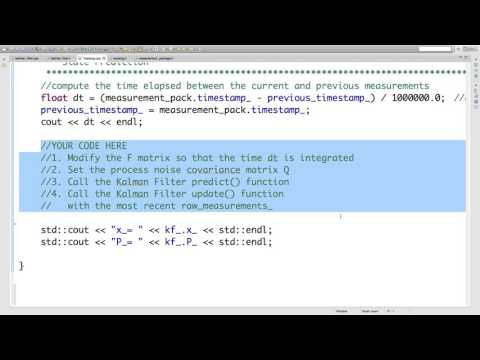

In [11]:
YouTubeVideo('gTEQHV_1E2k', width=960, height=540)

## Helpful Equations
You will be modifying these matrices in the Kalman Filter with the observed time step, dt.

$F
\begin{pmatrix}
1 & 0 & \Delta t & 0\\
0 & 1 & 0 & \Delta t\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{pmatrix}$

In the tracking class $\sigma^2_{ax}$ = noise_ax and $\sigma^2_{ay}$= noise_ay

$Q
\begin{pmatrix}
\frac{\Delta t^4}{4} \sigma_{ax}^2 & 0 & \frac{\Delta t^3}{2} \sigma_{ax}^2 & 0\\
0 & \frac{\Delta t^4}{4} \sigma_{ay}^2 & 0 & \frac{\Delta t^3}{2} \sigma_{ay}^2\\
\frac{\Delta t^3}{2}\sigma_{ax}^2& 0 & \Delta t^2 \sigma_{ax}^2 & 0\\
0 & \frac{\Delta t^3}{2} \sigma_{ay}^2 & 0 & \Delta t^2 \sigma_{ay}^2
\end{pmatrix}$

## main.cpp

```c++
#include <fstream>
#include <iostream>
#include <sstream>
#include <vector>
#include "Dense"
#include "measurement_package.h"
#include "tracking.h"

using namespace std;
using Eigen::MatrixXd;
using Eigen::VectorXd;
using std::vector;


int main() {

	/*******************************************************************************
	 *  Set Measurements															 *
	 *******************************************************************************/
	vector<MeasurementPackage> measurement_pack_list;

	// hardcoded input file with laser and radar measurements
	string in_file_name_ = "obj_pose-laser-radar-synthetic-input.txt";
	ifstream in_file(in_file_name_.c_str(),std::ifstream::in);

	if (!in_file.is_open()) {
		cout << "Cannot open input file: " << in_file_name_ << endl;
	}

	string line;
	// set i to get only first 3 measurments
	int i = 0;
	while(getline(in_file, line) && (i<=3)){

		MeasurementPackage meas_package;

		istringstream iss(line);
		string sensor_type;
		iss >> sensor_type;	//reads first element from the current line
		int64_t timestamp;
		if(sensor_type.compare("L") == 0){	//laser measurement
			//read measurements
			meas_package.sensor_type_ = MeasurementPackage::LASER;
			meas_package.raw_measurements_ = VectorXd(2);
			float x;
			float y;
			iss >> x;
			iss >> y;
			meas_package.raw_measurements_ << x,y;
			iss >> timestamp;
			meas_package.timestamp_ = timestamp;
			measurement_pack_list.push_back(meas_package);

		}else if(sensor_type.compare("R") == 0){
			//Skip Radar measurements
			continue;
		}
		i++;

	}

	//Create a Tracking instance
	Tracking tracking;

	//call the ProcessingMeasurement() function for each measurement
	size_t N = measurement_pack_list.size();
	for (size_t k = 0; k < N; ++k) {	//start filtering from the second frame (the speed is unknown in the first frame)
		tracking.ProcessMeasurement(measurement_pack_list[k]);
		
	}

	if(in_file.is_open()){
		in_file.close();
	}
	return 0;
}
```

## kalman_filter.cpp

```c++
#include "kalman_filter.h"

KalmanFilter::KalmanFilter() {
}

KalmanFilter::~KalmanFilter() {
}

void KalmanFilter::Predict() {
	x_ = F_ * x_;
	MatrixXd Ft = F_.transpose();
	P_ = F_ * P_ * Ft + Q_;
}

void KalmanFilter::Update(const VectorXd &z) {
	VectorXd z_pred = H_ * x_;
	VectorXd y = z - z_pred;
	MatrixXd Ht = H_.transpose();
	MatrixXd S = H_ * P_ * Ht + R_;
	MatrixXd Si = S.inverse();
	MatrixXd PHt = P_ * Ht;
	MatrixXd K = PHt * Si;

	//new estimate
	x_ = x_ + (K * y);
	long x_size = x_.size();
	MatrixXd I = MatrixXd::Identity(x_size, x_size);
	P_ = (I - K * H_) * P_;
}

```

## kalman_filter.h

```c++
#ifndef KALMAN_FILTER_H_
#define KALMAN_FILTER_H_
#include "Dense"

using Eigen::MatrixXd;
using Eigen::VectorXd;

class KalmanFilter {
public:

	///* state vector
	VectorXd x_;

	///* state covariance matrix
	MatrixXd P_;

	///* state transistion matrix
	MatrixXd F_;

	///* process covariance matrix
	MatrixXd Q_;

	///* measurement matrix
	MatrixXd H_;

	///* measurement covariance matrix
	MatrixXd R_;

	/**
	 * Constructor
	 */
	KalmanFilter();

	/**
	 * Destructor
	 */
	virtual ~KalmanFilter();

	/**
	 * Predict Predicts the state and the state covariance
	 * using the process model
	 */
	void Predict();

	/**
	 * Updates the state and
	 * @param z The measurement at k+1
	 */
	void Update(const VectorXd &z);

};

#endif /* KALMAN_FILTER_H_ */

```

## tracking.cpp

```c++
#include "Dense"
#include <iostream>
#include "tracking.h"

using namespace std;
using Eigen::MatrixXd;
using Eigen::VectorXd;
using std::vector;

Tracking::Tracking() {
	is_initialized_ = false;
	previous_timestamp_ = 0;

	//create a 4D state vector, we don't know yet the values of the x state
	kf_.x_ = VectorXd(4);

	//state covariance matrix P
	kf_.P_ = MatrixXd(4, 4);
	kf_.P_ << 1, 0, 0, 0,
			  0, 1, 0, 0,
			  0, 0, 1000, 0,
			  0, 0, 0, 1000;


	//measurement covariance
	kf_.R_ = MatrixXd(2, 2);
	kf_.R_ << 0.0225, 0,
			  0, 0.0225;

	//measurement matrix
	kf_.H_ = MatrixXd(2, 4);
	kf_.H_ << 1, 0, 0, 0,
			  0, 1, 0, 0;

	//the initial transition matrix F_
	kf_.F_ = MatrixXd(4, 4);
	kf_.F_ << 1, 0, 1, 0,
			  0, 1, 0, 1,
			  0, 0, 1, 0,
			  0, 0, 0, 1;

	//set the acceleration noise components
	noise_ax = 5;
	noise_ay = 5;

}

Tracking::~Tracking() {

}

// Process a single measurement
void Tracking::ProcessMeasurement(const MeasurementPackage &measurement_pack) {
	if (!is_initialized_) {
		//cout << "Kalman Filter Initialization " << endl;

		//set the state with the initial location and zero velocity
		kf_.x_ << measurement_pack.raw_measurements_[0], measurement_pack.raw_measurements_[1], 0, 0;

		previous_timestamp_ = measurement_pack.timestamp_;
		is_initialized_ = true;
		return;
	}

	//compute the time elapsed between the current and previous measurements
	float dt = (measurement_pack.timestamp_ - previous_timestamp_) / 1000000.0;	//dt - expressed in seconds
	previous_timestamp_ = measurement_pack.timestamp_;
	
    // TODO: YOUR CODE HERE
	//1. Modify the F matrix so that the time is integrated
	//2. Set the process covariance matrix Q
	//3. Call the Kalman Filter predict() function
	//4. Call the Kalman Filter update() function
	// with the most recent raw measurements_
	
	std::cout << "x_= " << kf_.x_ << std::endl;
	std::cout << "P_= " << kf_.P_ << std::endl;

}
```

## tracking.h

```c++

#ifndef TRACKING_H_
#define TRACKING_H_

#include "measurement_package.h"
#include <vector>
#include <string>
#include <fstream>
#include "kalman_filter.h"

class Tracking {
public:
	Tracking();
	virtual ~Tracking();
	void ProcessMeasurement(const MeasurementPackage &measurement_pack);
	KalmanFilter kf_;

private:
	bool is_initialized_;
	int64_t previous_timestamp_;

	//acceleration noise components
	float noise_ax;
	float noise_ay;

};

#endif /* TRACKING_H_ */
```

## measurement_package.h

```c++
#ifndef MEASUREMENT_PACKAGE_H_
#define MEASUREMENT_PACKAGE_H_

#include "Dense"

class MeasurementPackage {
public:
	int64_t timestamp_;

	enum SensorType {
		LASER, RADAR
	} sensor_type_;

	Eigen::VectorXd raw_measurements_;

};

#endif /* MEASUREMENT_PACKAGE_H_ */
```

# 13. Laser Measurements Part 4

Here's the solution and a code editor with my solution for you to experiment!

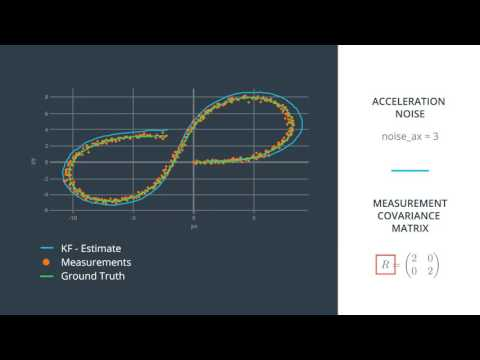

In [12]:
YouTubeVideo('udsB-13ntY8', width=960, height=540)

## solution: tracking.cpp

```c++
#include "Dense"
#include <iostream>
#include "tracking.h"

using namespace std;
using Eigen::MatrixXd;
using Eigen::VectorXd;
using std::vector;

Tracking::Tracking() {
	is_initialized_ = false;
	previous_timestamp_ = 0;

	//create a 4D state vector, we don't know yet the values of the x state
	kf_.x_ = VectorXd(4);

	//state covariance matrix P
	kf_.P_ = MatrixXd(4, 4);
	kf_.P_ << 1, 0, 0, 0,
			  0, 1, 0, 0,
			  0, 0, 1000, 0,
			  0, 0, 0, 1000;


	//measurement covariance
	kf_.R_ = MatrixXd(2, 2);
	kf_.R_ << 0.0225, 0,
			  0, 0.0225;

	//measurement matrix
	kf_.H_ = MatrixXd(2, 4);
	kf_.H_ << 1, 0, 0, 0,
			  0, 1, 0, 0;

	//the initial transition matrix F_
	kf_.F_ = MatrixXd(4, 4);
	kf_.F_ << 1, 0, 1, 0,
			  0, 1, 0, 1,
			  0, 0, 1, 0,
			  0, 0, 0, 1;

	//set the acceleration noise components
	noise_ax = 5;
	noise_ay = 5;

}

Tracking::~Tracking() {

}

// Process a single measurement
void Tracking::ProcessMeasurement(const MeasurementPackage &measurement_pack) {
	if (!is_initialized_) {
		//cout << "Kalman Filter Initialization " << endl;

		//set the state with the initial location and zero velocity
		kf_.x_ << measurement_pack.raw_measurements_[0], measurement_pack.raw_measurements_[1], 0, 0;

		previous_timestamp_ = measurement_pack.timestamp_;
		is_initialized_ = true;
		return;
	}

	//compute the time elapsed between the current and previous measurements
	float dt = (measurement_pack.timestamp_ - previous_timestamp_) / 1000000.0;	//dt - expressed in seconds
	previous_timestamp_ = measurement_pack.timestamp_;

	float dt_2 = dt * dt;
	float dt_3 = dt_2 * dt;
	float dt_4 = dt_3 * dt;

	//Modify the F matrix so that the time is integrated
	kf_.F_(0, 2) = dt;
	kf_.F_(1, 3) = dt;

	//set the process covariance matrix Q
	kf_.Q_ = MatrixXd(4, 4);
	kf_.Q_ <<  dt_4/4*noise_ax, 0, dt_3/2*noise_ax, 0,
			   0, dt_4/4*noise_ay, 0, dt_3/2*noise_ay,
			   dt_3/2*noise_ax, 0, dt_2*noise_ax, 0,
			   0, dt_3/2*noise_ay, 0, dt_2*noise_ay;

	//predict
	kf_.Predict();

	//measurement update
	kf_.Update(measurement_pack.raw_measurements_);

	std::cout << "x_= " << kf_.x_ << std::endl;
	std::cout << "P_= " << kf_.P_ << std::endl;

}
```

# 14. Radar Measurements

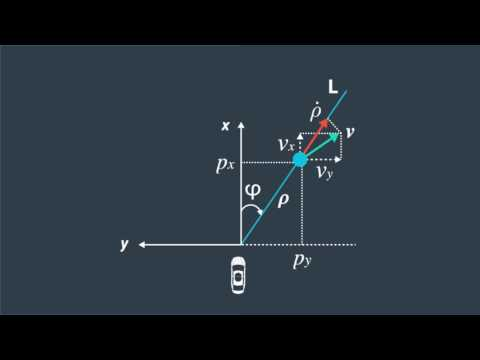

In [13]:
YouTubeVideo('LOz9AaHvB8M', width=960, height=540)

## H versus h(x)
The $H$ matrix from the lidar lesson and $h(x)$ equations from the radar lesson are actually accomplishing the same thing; they are both needed to solve $y = z - Hx'$ in the update step.

But for radar, there is no $H$ matrix that will map the state vector $x$ into polar coordinates; instead, you need to calculate the mapping manually to convert from cartesian coordinates to polar coordinates.

Here is the $h$ function that specifies how the predicted position and speed get mapped to the polar coordinates of range, bearing and range rate.

$h(x')= \begin{pmatrix}
\rho\\
\phi\\
\dot{\rho}
\end{pmatrix} =
\begin{pmatrix} 
\sqrt{ p{'}_x^2 + p{'}_y^2 }\\
\arctan(p_y' / p_x')\\
\frac{p_x' v_x' + p_y' v_y'}{\sqrt{p{'}_x^2 + p{'}_{y}^2}}
\end{pmatrix}$

Hence for radar $y = z - Hx'$ becomes $y = z - h(x')$.

## Definition of Radar Variables
- The range, ($\rho$), is the distance to the pedestrian. The range is basically the magnitude of the position vector $\rho$ which can be defined as $\rho = sqrt(p^2_x + p^2_y)$.
- $\phi =atan(p_y / p_x)$. Note that $\phi$ is referenced counter-clockwise from the x-axis, so $\phi$ from the video clip above in that situation would actually be negative.
- The range rate, $\rho$, is the projection of the velocity, $v$, onto the line, $L$.

## Deriving the Radar Measurement Function
The measurement function is composed of three components that show how the predicted state, $x' = (p'_x, p'_y, v'_x, v'_y)^T$, is mapped into the measurement space, $z = (\rho, \phi, \dot{\rho})^T$:
1. The range, $\rho$, is the distance to the pedestrian which can be defined as: <br>
$\rho = \sqrt{p^2_x + p^2_y}$

2. $\phi$ is the angle between $\rho$ and the $x$ direction and can be defined as: <br>
$\phi = arctan(p_y / p_x)$

3. There are two ways to do the range rate $\rho(t)$ derivation: <br>

# CONTENT TO BE ADDED
    1. Generally we can explicitly describe the range, $\rho$, as a function of time: Attachment_8.pngThe range rate, Attachment_7.png, is defined as time rate of change of the range, Attachment_2.png, and it can be described as the time derivative of Attachment_2.png: Attachment_9.png Attachment_10.png Attachment_11.png is nothing else than Attachment_12.png, similarly Attachment_13.png is Attachment_14.png. So we have: Attachment_15.png Attachment_16.pngFor simplicity we just use the following notation: Attachment_17.png	1.	The range rate, Attachment_18.png, can be seen as a scalar projection of the velocity vector, Attachment_19.png, onto Attachment_20.png. Both Attachment_20.png and Attachment_19.png are 2D vectors defined as:
<span class="mathquill">

$\vec{\rho}=
\begin{pmatrix}
p_x\\
p_y
\end{pmatrix}, \space
\vec{v}=\begin{pmatrix}
v_x\\
v_y
\end{pmatrix}$

The scalar projection of the velocity vector Attachment_19.png onto Attachment_20.png is defined as:

$\dot{\rho}=
\frac{\vec{v} \vec{\rho}}{\lvert \vec{\rho} \rvert} = 
\frac{
\begin{pmatrix}
v_x & v_y
\end{pmatrix}
\begin{pmatrix}
p_x\\
p_y
\end{pmatrix}
}{
\sqrt{p_x^2 + p_y^2}
}=\frac{p_x v_x + p_y v_y}{ \sqrt{p_x^2 + p_y^2}} $
where  is the length of Attachment_20.png. In our case it is

# CONTENT TO BE ADDED

The Next Quiz

$\begin{pmatrix}
\rho\\
\phi\\
\dot{\rho}
\end{pmatrix}
\leftarrow h(x)
\begin{pmatrix}
p_x'\\
p_y'\\
v_x'\\
v_y'
\end{pmatrix}$

Attachment.png is a nonlinear function. In the next quiz I would like to check your intuition about what that means.

# 15. Mapping with a Nonlinear Function

<img src="img/screenshot-from-2017-02-27-19-02-34.png" width=600>

## QUIZ QUESTION

What happens if we have a nonlinear measurement function, h(x). Can we apply the Kalman Filter equations to update the predicted state, X, with new measurements, z?

- (A) Yes! We have defined both the motion model and the measurement model so we should be good to go.
- (B) No! We aren't working with Gaussian distributions after applying a nonlinear measurement function.

Answer: B

# 16. Extended Kalman Filter

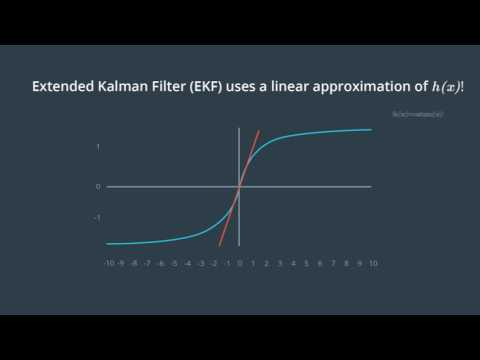

In [14]:
YouTubeVideo('nMUd_esBMM8', width=960, height=540)

<img src="img/screenshot-from-2017-02-27-19-06-36.png">
<center>Follow the arrows from top left to bottom to top right: (1) A Gaussian from 10,000 random values in a normal distribution with a mean of 0. (2) Using a nonlinear function, arctan, to transform each value. (3) The resulting distribution.</center>

<img src="img/screenshot-from-2017-02-27-19-08-41.png">
<center>This one looks much better! Notice how the blue graph, the output, remains a Gaussian after applying a first order Taylor expansion.</center>

## How to Perform a Taylor Expansion
The general form of a [Taylor series expansion](https://en.wikipedia.org/wiki/Taylor_series) of an equation, f(x), at point μ is as follows:

$f(x) \approx f(\mu)+ \frac{\partial f(\mu)}{\partial x}(x - \mu)$


Simply replace $f(x)$ with a given equation, find the partial derivative, and plug in the value $\mu$ to find the Taylor expansion at that value of $\mu$.

See if you can find the Taylor expansion of $arctan(x)$.

Let’s say we have a predicted state density described by

$\mu=0$ and $\sigma=3$.

The function that projects the predicted state, $x$, to the measurement space $z$ is

$h(x)=arctan(x)$.

and its partial derivative is

$\partial h=1/(1+x^2)$.

I want you to use the first order Taylor expansion to construct a linear approximation of $h(x)$ to find the equation of the line that linearizes the function $h(x)$ at the mean location $\mu$.

<img src="img/screenshot-from-2017-02-27-19-14-14.png">
<center>The orange line represents the first order Taylor expansion of arctan(x). What is it?</center>

A) $h(x) \approx x$

B) $h(x) \approx 1/(1+x^2)$

C) $h(x) \approx x+arctan(x)$

D) $h(x) \approx 3+x$


## QUIZ QUESTION

Which of the above equations (↑) represents the first order Taylor expansion of arctan(x) around mu = 0?

Answer: (A)

# 17. Multivariate Taylor Series Expansion

## Solution to the Previous Quiz
### Solution
$h(x) \approx h(\mu) + \frac{\partial h(\mu)}{\partial x}(x-\mu) = \arctan(\mu) + \frac{1}{1+\mu^2}(x-\mu)$

In our example Attachment.png, therefore:

$h(x) \approx \arctan(0) + \frac{1}{1+0}(x-0) = x$.

So, the function, $h(x) = \arctan(x)$, will be approximated by a line: $h(x) \approx x$.

And now, let's keep going!

## Multivariate Taylor Series
Now that you’ve seen how to do a Taylor series expansion with a one-dimensional equation, we’ll need to look at the Taylor series expansion for multi-dimensional equations. Recall from the *Radar Measurements lecture* that the h function is composed of three equations that show how the predicted state, $x'= (p'_x, p'_y, v'_x, v'_y)^T$, is mapped into the measurement space, $z = (\rho, \phi, \dot{\rho})^T$:

$h(x')= \begin{pmatrix}
\sqrt{ p{'}_x^2 + p{'}_y^2 }\\
\arctan(p_y' / p_x')\\
\frac{p_x' v_x' + p_y' v_y'}{\sqrt{p{'}_x^2 + p{'}_{y}^2}}
\end{pmatrix}$

These are multi-dimensional equations, so we will need to use a multi-dimensional Taylor series expansion to make a linear approximation of the $h$ function. Here is a general formula for the multi-dimensional Taylor series expansion:

$T(x) = f(a) + (x - a)^TDf(a) + \frac 1{2!}(x-a)^T{D^2f(a)}(x - a) + ...$

where $Df(a)$ is called the Jacobian matrix and $D^2f(a)$ is called the Hessian matrix. They represent first order and second order derivatives of multi-dimensional equations. A full Taylor series expansion would include higher order terms as well for the third order derivatives, fourth order derivatives, and so on.

Notice the similarities between the multi-dimensional Taylor series expansion and the one-dimensional Taylor series expansion:

$T(x) = f(a) + \frac{f'(a)}{1!}(x - a) + \frac{f''(a)}{2!}(x-a)^2 + \frac{f'''(a)}{3!}(x - a)^3 + ...$

To derive a linear approximation for the $h$ function, we will only keep the expansion up to the Jacobian matrix $Df(a)$. We will ignore the Hessian matrix $D^2f(a)$ and other higher order terms. Assuming $(x−a)$ is small, $(x−a)^
2$ or the multi-dimensional equivalent $(x−a)^T(x−a)$ will be even smaller; the extended Kalman filter we'll be using assumes that higher order terms beyond the Jacobian are negligible.

Let's first calculate the Jacobian matrix for the extended Kalman filter. Then we'll show the difference between the Kalman filter equations and the extended Kalman filter equations.


# 18. Jacobian Matrix Part 1

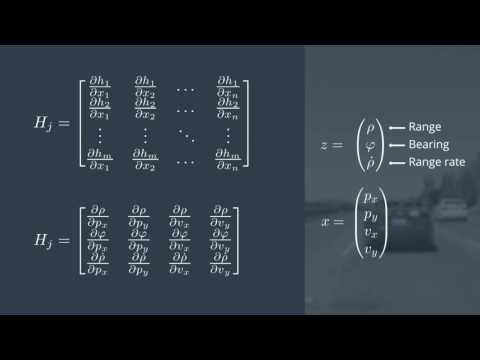

In [15]:
YouTubeVideo('FeE5cRlMZqU', width=960, height=540)

At 1:59 Andrei says, "you have to check that neither x nor y is zero." What is meant is: "you have to check that x and y are not both zero".

We're going to calculate, step by step, all the partial derivatives in $H_j$ :

$H_j = 
\begin{bmatrix}
\frac{\partial \rho}{\partial p_x} & \frac{\partial \rho}{\partial p_y} & \frac{\partial \rho}{\partial v_x} & \frac{\partial \rho}{\partial v_y}\\
\frac{\partial \varphi}{\partial p_x} & \frac{\partial \varphi}{\partial p_y} & \frac{\partial \varphi}{\partial v_x} & \frac{\partial \varphi}{\partial v_y}\\
\frac{\partial \dot{\rho}}{\partial p_x} & \frac{\partial \dot{\rho}}{\partial p_y} & \frac{\partial \dot{\rho}}{\partial v_x} & \frac{\partial \dot{\rho}}{\partial v_y} \end{bmatrix}$

So all of $H_j$'s elements are calculated as follows:

$\frac{\partial \rho}{\partial p_x}=
\frac{\partial}{\partial p_x}(\sqrt[]{p_x^2 + p_y^2}) = 
\frac{2 p_x}{2 \sqrt[]{p_x^2 + p_y^2}} = 
\frac{p_x}{\sqrt[]{p_x^2 + p_y^2}}$

$\frac{\partial \rho}{\partial p_y}=
\frac{\partial}{\partial p_y}(\sqrt[]{p_x^2 + p_y^2}) = 
\frac{2 p_y}{2 \sqrt[]{p_x^2 + p_y^2}} = 
\frac{p_y}{\sqrt[]{p_x^2 + p_y^2}}$

$\frac{\partial \rho}{\partial v_x} = 
\frac{\partial}{\partial v_x}(\sqrt[]{p_x^2 + p_y^2}) = 0$

$\frac{\partial \rho}{\partial v_y} = 
\frac{\partial}{\partial v_y}(\sqrt[]{p_x^2 + p_y^2}) = 0$

$\frac{\partial \varphi}{\partial p_x} =
\frac{\partial}{\partial p_x}arctan(p_y/p_x) =
\frac{1}{(\frac{p_y}{p_x})^2 + 1} (- \frac{p_y}{p_x^2}) = -\frac{p_y}{p_x^2+p_y^2}$

$\frac{\partial \varphi}{\partial p_y} =
\frac{\partial}{\partial p_y}arctan(p_y/p_x) =
\frac{1}{(\frac{p_y}{p_x})^2 + 1} (\frac{1}{p_x}) = \frac{p_x^2}{p_x^2+p_y^2} \frac{1}{p_x} =\frac{p_x}{p_x^2+p_y^2}$

$\frac{\partial \varphi}{\partial v_x} =
\frac{\partial}{\partial v_x}arctan(p_y/p_x) = 0$

$\frac{\partial \varphi}{\partial v_y} =
\frac{\partial}{\partial v_y}arctan(p_y/p_x) = 0$

$\frac{\partial \dot{\rho}}{\partial p_x} =
\frac{\partial}{\partial p_x} \left( \frac{p_x v_x + p_y v_y}{\sqrt[]{p_x^2 + p_y^2}} \right) $

In order to calculate the derivative of this function we use the quotient rule.

Given a function $z$ that is quotient of two other functions, $f$ and $g$:

$z = \frac{f}{g}$

its derivative with respect to $x$ is defined as:

$\frac{\partial z}{\partial x} =
\frac
{
\frac{\partial f}{\partial x} g - 
\frac{\partial g}{\partial x} f
}
{g^2}$

in our case: 

$f = p_x v_x + p_y v_y$

$g = \sqrt[]{p_x^2 + p_y^2}$

Their derivatives are:

$\frac{\partial f}{\partial p_x} = \frac{\partial}{\partial p_x} (p_x v_x + p_y v_y) = v_x$

$\frac{\partial g}{\partial p_x} = \frac{\partial}{\partial p_x} \left( \sqrt[]{p_x^2 + p_y^2} \right) = \frac{p_x}{\sqrt[]{p_x^2 + p_y^2}}$

Putting everything together into the derivative quotient rule we have:

$\frac{\partial \dot{\rho}} {\partial p_x} = \frac{v_x \sqrt[]{p_x^2 + p_y^2} - \frac{p_x}{\sqrt[]{p_x^2 + p_y^2}} (p_x v_x + p_y v_y)}
{p_x^2 + p_y^2}
\frac{p_y(v_x p_y - v_y p_x)}{(p_x^2 + p_y^2)^{3/2}}$

Similarly

$\frac{\partial \dot{\rho}}{\partial p_y}
\frac{\partial}{\partial p_y} \left( \frac{p_x v_x + p_y v_y}{\sqrt[]{p_x^2 + p_y^2}} \right)
\frac{p_x(v_y p_x - v_x p_y)}{(p_x^2 + p_y^2)^{3/2}}$

$\frac{\partial \dot{\rho}}{\partial v_x}
\frac{\partial}{\partial v_x} \left( \frac{p_x v_x + p_y v_y}{\sqrt[]{p_x^2 + p_y^2}} \right)
\frac{p_x}{\sqrt[]{p_x^2 + p_y^2}}$

$\frac{\partial \dot{\rho}}{\partial v_y}
\frac{\partial}{\partial v_y} \left( \frac{p_x v_x + p_y v_y}{\sqrt[]{p_x^2 + p_y^2}} \right)
\frac{p_y}{\sqrt[]{p_x^2 + p_y^2}}$

So now, after calculating all the partial derivatives, our resulted Jacobian, $H_j$ is:

$H_j = \begin{bmatrix}
\frac{p_x}{\sqrt[]{p_x^2 + p_y^2}} & \frac{p_y}{\sqrt[]{p_x^2 + p_y^2}} & 0 & 0\\
-\frac{p_y}{p_x^2 + p_y^2} & \frac{p_x}{p_x^2 + p_y^2} & 0 & 0\\
\frac{p_y(v_x p_y - v_y p_x)}{(p_x^2 + p_y^2)^{3/2}} & \frac{p_x(v_y p_x - v_x p_y)}{(p_x^2 + p_y^2)^{3/2}} & \frac{p_x}{\sqrt[]{p_x^2 + p_y^2}} & \frac{p_y}{\sqrt[]{p_x^2 + p_y^2}}\\
\end{bmatrix}$

## Jacobian Matrix Programming Quiz

FIll in the missing code in the `CalculateJacobian()` function to return the correct Jacobian matrix.

```c++
#include <iostream>
#include "Dense"
#include <vector>

using namespace std;
using Eigen::MatrixXd;
using Eigen::VectorXd;

MatrixXd CalculateJacobian(const VectorXd& x_state);

int main() {

	/*
	 * Compute the Jacobian Matrix
	 */

	//predicted state  example
	//px = 1, py = 2, vx = 0.2, vy = 0.4
	VectorXd x_predicted(4);
	x_predicted << 1, 2, 0.2, 0.4;

	MatrixXd Hj = CalculateJacobian(x_predicted);

	cout << "Hj:" << endl << Hj << endl;

	return 0;
}

MatrixXd CalculateJacobian(const VectorXd& x_state) {

	MatrixXd Hj(3,4);
	//recover state parameters
	float px = x_state(0);
	float py = x_state(1);
	float vx = x_state(2);
	float vy = x_state(3);

	//TODO: YOUR CODE HERE 

	//check division by zero
	
	//compute the Jacobian matrix

	return Hj;
}
```

# 19. Jacobian Matrix Part 2

Here's the solution for the quiz followed by a code editor where you'll be able to play with the solution.

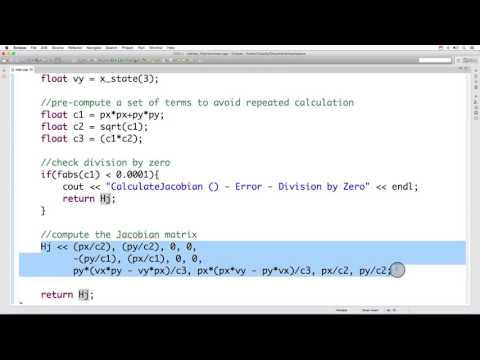

In [16]:
YouTubeVideo('pRhuwlMhG3o', width=960, height=540)

```c++
#include <iostream>
#include "Dense"
#include <vector>

using namespace std;
using Eigen::MatrixXd;
using Eigen::VectorXd;

MatrixXd CalculateJacobian(const VectorXd& x_state);

int main() {

	/*
	 * Compute the Jacobian Matrix
	 */

	//predicted state  example
	//px = 1, py = 2, vx = 0.2, vy = 0.4
	VectorXd x_predicted(4);
	x_predicted << 1, 2, 0.2, 0.4;

	MatrixXd Hj = CalculateJacobian(x_predicted);

	cout << "Hj:" << endl << Hj << endl;

	return 0;
}

MatrixXd CalculateJacobian(const VectorXd& x_state) {

	MatrixXd Hj(3,4);
	//recover state parameters
	float px = x_state(0);
	float py = x_state(1);
	float vx = x_state(2);
	float vy = x_state(3);

	//pre-compute a set of terms to avoid repeated calculation
	float c1 = px*px+py*py;
	float c2 = sqrt(c1);
	float c3 = (c1*c2);

	//check division by zero
	if(fabs(c1) < 0.0001){
		cout << "CalculateJacobian () - Error - Division by Zero" << endl;
		return Hj;
	}

	//compute the Jacobian matrix
	Hj << (px/c2), (py/c2), 0, 0,
		  -(py/c1), (px/c1), 0, 0,
		  py*(vx*py - vy*px)/c3, px*(px*vy - py*vx)/c3, px/c2, py/c2;

	return Hj;
}
```

# 20. EKF Algorithm Generalization

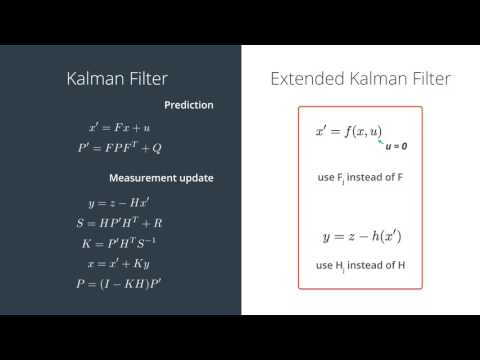

In [18]:
YouTubeVideo('co0ZczAuwdM', width=960, height=540)

## Extended Kalman Filter Equations
Although the mathematical proof is somewhat complex, it turns out that the Kalman filter equations and extended Kalman filter equations are very similar. The main differences are:

- the $F$ matrix will be replaced by $F_j$ when calculating $P′$.
- the $H$ matrix in the Kalman filter will be replaced by the Jacobian matrix $H_j$ when calculating $S$, $K$, and $P$.
- to calculate $x′$, the prediction update function, $f$, is used instead of the $F$ matrix.
- to calculate $y$, the $h$ function is used instead of the $H$ matrix.

For this project, however, we do not need to use the $f$ function or $F_j$. If we had been using a non-linear model in the prediction step, we would need to replace the $F$ matrix with its Jacobian, $F_j$. However, we are using a linear model for the prediction step. So, for the prediction step, we can still use the regular Kalman filter equations and the F matrix rather than the extended Kalman filter equations.

The measurement update for lidar will also use the regular Kalman filter equations, since lidar uses linear equations. Only the measurement update for the radar sensor will use the extended Kalman filter equations.

**One important point to reiterate is that the equation $y=z−Hx′$ for the Kalman filter does not become $y=z−H_jx$ for the extended Kalman filter. Instead, for extended Kalman filters, we'll use the h function directly to map predicted locations $x′$ from Cartesian to polar coordinates.**

<img src="img/algorithm-generalization-900.jpg">
<center>The comparison for reference.</center>

## Clarification of u = 0
In the above image, the prediction equation is written as $x′=Fx+u$ and $x′=f(x,u)$. Previously the equation was written $x′=Fx+ν$.

It is just a question of notation where ν is the greek letter "nu" and "u" is used in the code examples. Remember that ν is represented by a gaussian distribution with mean zero. The equation $x′=Fx+u$ or the equivalent equation $x′=Fx+ν$ calculates the mean value of the state variable $x$; hence we set u = 0. The uncertainty in the gaussian distribution shows up in the $Q$ matrix.

## More Details About Calculations with Radar Versus Lidar
In the radar update step, the Jacobian matrix $H_j$ is used to calculate $S$, $K$ and $P$. To calculate $y$, we use the equations that map the predicted location $x′$ from Cartesian coordinates to polar coordinates:

$h(x')= \begin{pmatrix}
\sqrt{ p{'}_{x}^2 + p{'}_{y}^2 }\\
\arctan(p_y' / p_x')\\
\frac{p_x' v_x' + p_y' v_y'}{\sqrt{p{'}_{x}^2 + p{'}_{y}^2}}
\end{pmatrix}
$

The predicted measurement vector $x'$ is a vector containing values in the form 
$\begin{bmatrix}
p_x, p_y, v_x, v_y
\end{bmatrix}$

The radar sensor will output values in polar coordinates:

$\begin{pmatrix}
\rho\\
\phi\\
\dot{\rho}
\end{pmatrix}$

In order to calculate $y$ for the radar sensor, we need to convert $x′$ to polar coordinates. In other words, the function $h(x)$ maps values from Cartesian coordinates to polar coordinates. So the equation for radar becomes $y=z
_{radar}−h(x′)$.

One other important point when calculating $y$ with radar sensor data: the second value in the polar coordinate vector is the angle $ϕ$. You'll need to make sure to normalize $ϕ$ in the $y$ vector so that its angle is between $−pi$ and $pi$; in other words, add or subtract $2pi$ from $ϕ$ until it is between $−pi$ and $pi$.

To summarize:

- for measurement updates with lidar, we can use the $H$ matrix for calculating $y$, $S$, $K$ and $P$.
- for radar, $H_j$ is used to calculate $S$, $K$ and $P$.

## QUIZ QUESTION

Compared to Kalman Filters, how would the Extended Kalman Filter result differ when the prediction function and measurement function are both linear?

- (A) The Extended Kalman Filter's result would be the same as the standard Kalman Filter's result.
- (B) The Extended Kalman Filter's result would vary unpredictably compared to the Kalman Filter's result.
- (C) The Extended Kalman Filter's result would be less accrurate than the Kalman Filter's result.
- (D) The Extended Kalman Filter's result would be more accurate than the Kalman Filter's result.

Answer: (A). If f and h are linear functions, then the Extended Kalman Filter generates exactly the same result as the standard Kalman Filter. Actually, if f and h are linear then the Extended Kalman Filter $F_j$ turns into $f$ and $H_j$ turns into $h$. All that's left is the same ol' standard Kalman Filter!

In our case we have a linear motion model, but a nonlinear measurement model when we use radar observations. So, we have to compute the Jacobian only for the measurement function.

# 21. Sensor Fusion General Flow

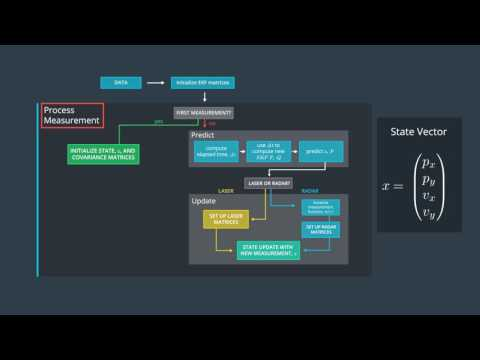

In [19]:
YouTubeVideo('dcTY4vRg5vo', width=960, height=540)

# 22. Evaluating KF Performance Part 1

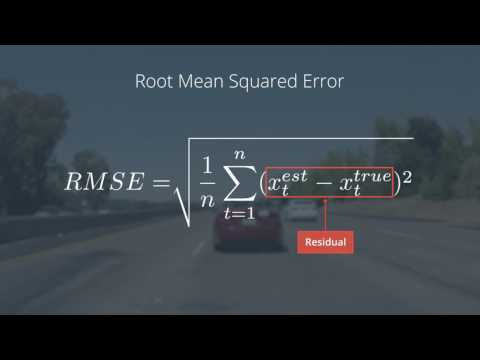

In [20]:
YouTubeVideo('1HieeV8IUv8', width=960, height=540)

```c++
#include <iostream>
#include "Dense"
#include <vector>

using namespace std;
using Eigen::MatrixXd;
using Eigen::VectorXd;
using std::vector;

VectorXd CalculateRMSE(const vector<VectorXd> &estimations,
		const vector<VectorXd> &ground_truth);

int main() {
	/*
	 * Compute RMSE
	 */
	vector<VectorXd> estimations;
	vector<VectorXd> ground_truth;

	//the input list of estimations
	VectorXd e(4);
	e << 1, 1, 0.2, 0.1;
	estimations.push_back(e);
	e << 2, 2, 0.3, 0.2;
	estimations.push_back(e);
	e << 3, 3, 0.4, 0.3;
	estimations.push_back(e);

	//the corresponding list of ground truth values
	VectorXd g(4);
	g << 1.1, 1.1, 0.3, 0.2;
	ground_truth.push_back(g);
	g << 2.1, 2.1, 0.4, 0.3;
	ground_truth.push_back(g);
	g << 3.1, 3.1, 0.5, 0.4;
	ground_truth.push_back(g);

	//call the CalculateRMSE and print out the result
	cout << CalculateRMSE(estimations, ground_truth) << endl;


	return 0;
}

VectorXd CalculateRMSE(const vector<VectorXd> &estimations,
		const vector<VectorXd> &ground_truth){

	VectorXd rmse(4);
	rmse << 0,0,0,0;

    // TODO: YOUR CODE HERE

	// check the validity of the following inputs:
	//  * the estimation vector size should not be zero
	//  * the estimation vector size should equal ground truth vector size
	// ... your code here

	//accumulate squared residuals
	for(int i=0; i < estimations.size(); ++i){
        // ... your code here
		
	}

	//calculate the mean
	// ... your code here

	//calculate the squared root
	// ... your code here

	//return the result
	return rmse;
}
```

# 23. Evaluating KF Performance 2

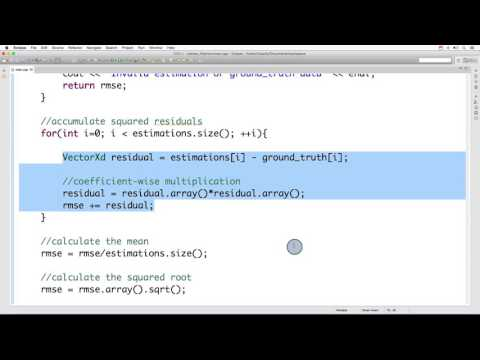

In [21]:
YouTubeVideo('1iVBYQ_KWXk', width=960, height=540)

```c++
#include <iostream>
#include "Dense"
#include <vector>

using namespace std;
using Eigen::MatrixXd;
using Eigen::VectorXd;
using std::vector;

VectorXd CalculateRMSE(const vector<VectorXd> &estimations,
		const vector<VectorXd> &ground_truth);

int main() {
	/*
	 * Compute RMSE
	 */
	vector<VectorXd> estimations;
	vector<VectorXd> ground_truth;

	//the input list of estimations
	VectorXd e(4);
	e << 1, 1, 0.2, 0.1;
	estimations.push_back(e);
	e << 2, 2, 0.3, 0.2;
	estimations.push_back(e);
	e << 3, 3, 0.4, 0.3;
	estimations.push_back(e);

	//the corresponding list of ground truth values
	VectorXd g(4);
	g << 1.1, 1.1, 0.3, 0.2;
	ground_truth.push_back(g);
	g << 2.1, 2.1, 0.4, 0.3;
	ground_truth.push_back(g);
	g << 3.1, 3.1, 0.5, 0.4;
	ground_truth.push_back(g);

	//call the CalculateRMSE and print out the result
	cout << CalculateRMSE(estimations, ground_truth) << endl;


	return 0;
}

VectorXd CalculateRMSE(const vector<VectorXd> &estimations,
		const vector<VectorXd> &ground_truth){

	VectorXd rmse(4);
	rmse << 0,0,0,0;

	// check the validity of the following inputs:
	//  * the estimation vector size should not be zero
	//  * the estimation vector size should equal ground truth vector size
	if(estimations.size() != ground_truth.size()
			|| estimations.size() == 0){
		cout << "Invalid estimation or ground_truth data" << endl;
		return rmse;
	}

	//accumulate squared residuals
	for(unsigned int i=0; i < estimations.size(); ++i){

		VectorXd residual = estimations[i] - ground_truth[i];

		//coefficient-wise multiplication
		residual = residual.array()*residual.array();
		rmse += residual;
	}

	//calculate the mean
	rmse = rmse/estimations.size();

	//calculate the squared root
	rmse = rmse.array().sqrt();

	//return the result
	return rmse;
}
```

# 24. Outro

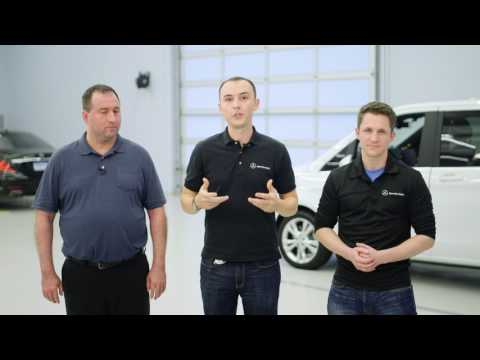

In [22]:
YouTubeVideo('k5VhLE0OoOM', width=960, height=540)